# 0. SETUP

## 0.1 Install Dependencies

In [1]:
!pip install opencv-python matplotlib shutil

     --------------------------------------- 38.2/38.2 MB 31.2 MB/s eta 0:00:00


## 0.2 Import Dependencies

In [1]:
import cv2
import os, stat
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt
import requests
import uuid

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### How the Model works
`inputImage` -> image that we want to verify

`verifactionImage` -> image stored to verify the image

`output` -> 1 if verified, 0 if not

Model(`input` = [inputImage,verifactionImage], `output`= [1 or 0])

## 0.3 Set GPU Growth

In [2]:
# Adjust VRAM consumption by TensorFlow in order to avoid OOM errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## 0.4 Create Folder Structures

In [3]:
POS_PATH = os.path.join("data","positive")
NEG_PATH = os.path.join("data","negative")
ANC_PATH = os.path.join("data","anchor")

In [ ]:

# makedirs creates the full path, mkdir only creates the final one
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 1. Collect Positives and Anchors

## 1.1 Getting Dataset - Labelled Faces in the Wild

### Download and Untar

In [14]:
# Download the Dataset
url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
request = requests.get(url, allow_redirects = True)

open("lfw.tgz","wb").write(request.content)

# Untar file
!tar -xf lfw.tgz

180566744

### Move LFW Images to data/negative

Make sure the folder is with write permissions

In [6]:
import shutil
for dir in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw",dir)):
        OLD_PATH = os.path.join("lfw",dir,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        shutil.copy(OLD_PATH,NEG_PATH)

## 1.2 Collect Positive and Anchor Classes

In [17]:
# Variables used
CAM_POS = 2 # Change this value accordingly to the pos of the camera youre using
X_CAM_POS = 230
Y_CAM_POS = 90
FRAME = 250

In [18]:
#Connection to web cam
cap = cv2.VideoCapture(CAM_POS)
while cap.isOpened():
    ret, frame = cap.read()
    # Cut fram to 250x250 px
    frame = frame[Y_CAM_POS:Y_CAM_POS+FRAME,X_CAM_POS:X_CAM_POS+FRAME]

    # Show image to screen
    cv2.imshow("Image Collection", frame)
        
    # Exit
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break
#Release webcam
cap.release()
#Close image
cv2.destroyAllWindows()

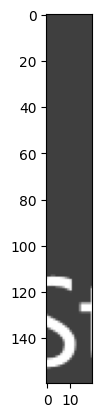

In [5]:
# Used to view image and position correctly the video capture

plt.imshow(frame[Y_CAM_POS:Y_CAM_POS+FRAME,X_CAM_POS:X_CAM_POS+FRAME])

# 2. Preprocessing

## 2.1 Dataset list files

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"\*.jpg").take(300)
pos = tf.data.Dataset.list_files(POS_PATH+"\*.jpg").take(300)
neg = tf.data.Dataset.list_files(NEG_PATH+"\*.jpg").take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\0e100f0e-ad89-11ed-a16d-001a7dda7115.jpg'

## 2.2 Scale and Resize

In [5]:
NUM_PIXELS = 105
def preprocess(file_path):

    # Reading image from file_path
    byte_img = tf.io.read_file(file_path)

    # Load the image, convert to jpeg
    img = tf.io.decode_jpeg(byte_img)

    # Resize to 105x105x3 ( According to paper )
    img = tf.image.resize(img,(NUM_PIXELS,NUM_PIXELS))

    # Normalize Image to be between 0 and 1
    img = img / 255.0
    
    return img

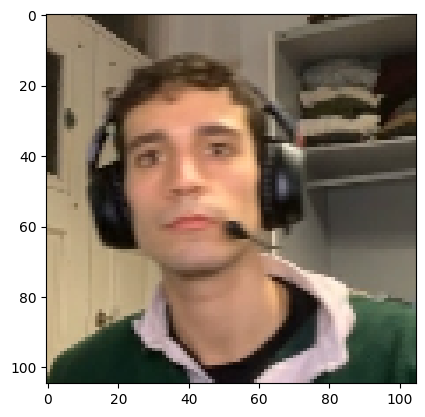

In [54]:
img = preprocess('data\\anchor\\0e100f0e-ad89-11ed-a16d-001a7dda7115.jpg')
plt.imshow(img)

In [15]:
img.numpy().min()

0.0

In [16]:
img.numpy().max()

1.0

## 2.3 Labelled Dataset

( anchor, pos ) => 1,1,1,1

( anchor, neg ) => 0,0,0,0

In [6]:
# Run only once
pos = tf.data.Dataset.zip((anchor, pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
neg = tf.data.Dataset.zip((anchor, neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = pos.concatenate(neg)

In [29]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

#### Example

In [42]:
class_lbls = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [43]:
it_labels = class_lbls.as_numpy_iterator()

In [45]:
it_labels.next()

0.0

In [55]:
smpls = data.as_numpy_iterator()

In [58]:
# (file_path anchor, file_path pos/neg, 0/1)
ex = smpls.next()

In [59]:
ex

(b'data\\anchor\\4cbf00ef-ad89-11ed-8a2d-001a7dda7115.jpg',
 b'data\\positive\\1067e460-ad89-11ed-a110-001a7dda7115.jpg',
 1.0)

## 2.4 Train and Test Partition

#### Preprocess label

In [7]:
def preprocess_label(input_img, val_img, lbl):
    # Returns (preprocessed anchor_image (as tensor), preprocessed pos/neg image (as tensor), label)
    return (preprocess(input_img), preprocess(val_img),lbl)

#### Example

In [62]:
pre_ex = preprocess_label(*ex)

In [63]:
pre_ex

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.67684186, 0.61017513, 0.5003713 ],
         [0.6681606 , 0.60149395, 0.49169   ],
         [0.66947895, 0.6028123 , 0.49300835],
         ...,
         [0.35190293, 0.32053038, 0.26954997],
         [0.33539417, 0.30402163, 0.25304124],
         [0.33576098, 0.30438843, 0.26125118]],
 
        [[0.67086834, 0.6042017 , 0.49439776],
         [0.6787115 , 0.6120448 , 0.5022409 ],
         [0.66704017, 0.6003735 , 0.49056956],
         ...,
         [0.3410231 , 0.30965054, 0.25867012],
         [0.3369748 , 0.30560225, 0.25462186],
         [0.3369748 , 0.30560225, 0.25462186]],
 
        [[0.6802054 , 0.61353874, 0.5037348 ],
         [0.67086834, 0.6042017 , 0.49439776],
         [0.6676382 , 0.6009715 , 0.49116758],
         ...,
         [0.33155927, 0.30018672, 0.24920633],
         [0.33028543, 0.29891288, 0.2479325 ],
         [0.32801118, 0.29663864, 0.24565826]],
 
        ...,
 
        [[0.23969358, 0.2967431 

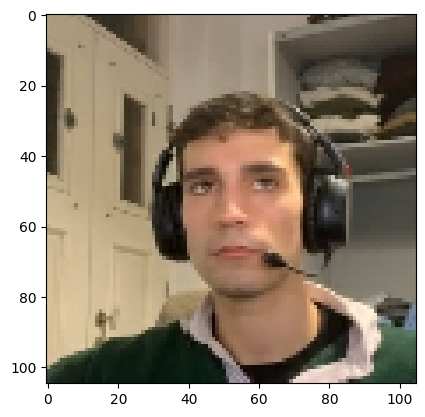

In [70]:
plt.imshow(pre_ex[0])

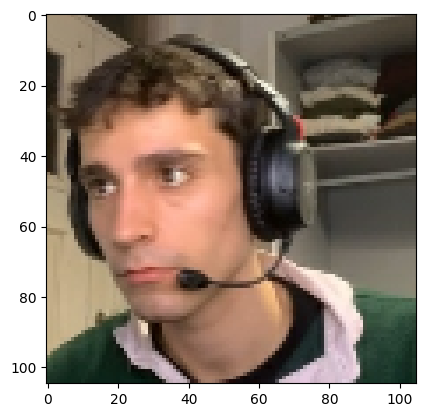

In [83]:
plt.imshow(pre_ex[1])

In [68]:
pre_ex[2]

1.0

#### DataLoader Pipeline

In [8]:
# Preprocess every tensor from data
data = data.map(preprocess_label)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [72]:
data

<ShuffleDataset shapes: ((105, 105, None), (105, 105, None), ()), types: (tf.float32, tf.float32, tf.float32)>

#### Example of a sample after preprocessing and shuffling

In [73]:
smpls = data.as_numpy_iterator()

In [88]:
ex = smpls.next()

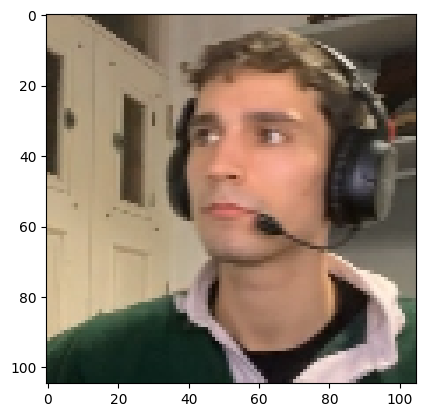

In [89]:
plt.imshow(ex[0])

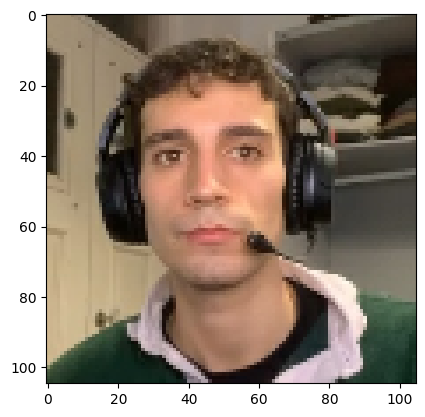

In [90]:
plt.imshow(ex[1])

In [91]:
ex[2]

1.0

### Training Partition

In [9]:
TRAIN_PER = 0.7
BATCH_SIZE = 16
PREFETCH_SIZE = 8

train_data = data.take(round(len(data)*TRAIN_PER))
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(PREFETCH_SIZE)

In [100]:
train_data

<PrefetchDataset shapes: ((None, 105, 105, None), (None, 105, 105, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

#### Testing Partition

In [10]:
test_data = data.skip(round(len(data)*TRAIN_PER))
test_data = data.take(round(len(data)*1-TRAIN_PER))
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(PREFETCH_SIZE)

# 3. Model Engineering

## 3.1 Embedding Layer

In [11]:
def embedding():
    inp = Input(shape=(NUM_PIXELS,NUM_PIXELS,3), name= "Input_Image")

    c2d1 = Conv2D(64, (10,10), activation= "relu")(inp)
    mp1 = MaxPooling2D(64, (2,2), padding="same")(c2d1)

    c2d2 = Conv2D(128, (7,7), activation= "relu")(mp1)
    mp2 = MaxPooling2D(64, (2,2), padding="same")(c2d2)

    c2d3 = Conv2D(128, (4,4), activation= "relu")(mp2)
    mp3 = MaxPooling2D(64, (2,2), padding="same")(c2d3)

    c2d4 = Conv2D(256, (4,4), activation= "relu")(mp3)
    f1 = Flatten()(c2d4)
    d1 = Dense(4096, activation="sigmoid")(f1)


    return Model(inputs = [inp], outputs = [d1], name = "embedding")


In [12]:
embedding = embedding()

#### Model Summary

In [20]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 3.2 Distance Layer

In [13]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, inp_embedding, val_embedding):
        return tf.math.abs(inp_embedding - val_embedding)

In [14]:
l1 = L1Dist()

## 3.3 Siamese Model

In [15]:
def siamese_model():
    inp_img = Input(name = "inp_img",shape = (NUM_PIXELS,NUM_PIXELS,3))
    val_img = Input(name = "val_img",shape = (NUM_PIXELS,NUM_PIXELS,3))

    siamese_layer = L1Dist()
    siamese_layer._name= "distance"
    distances = siamese_layer(embedding(inp_img),embedding(val_img))

    classifier = Dense(1,activation="sigmoid")(distances)

    return Model(inputs = [inp_img,val_img], outputs = classifier, name = "Siamese")

In [16]:
siamese_network = siamese_model()

#### Summary

In [23]:
siamese_network.summary()

Model: "Siamese Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_img (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
val_img (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    inp_img[0][0]                    
                                                                 val_img[0][0]                    
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]    

# 4. Training

## 4.1 Loss and Optimizer

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [18]:
adam_opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 4.2 Checkpoints

Load pre trained weights into existing model

`model.load`("path_to_checkpoint")

In [19]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(opt=adam_opt,siamese_model=siamese_network)

In [27]:
os.mkdir(checkpoint_dir)

## 4.3 Train Step Function

In [20]:
tf.config.run_functions_eagerly(True)

In [21]:
@tf.function
def training_step(batch):

    # Records automatic differantiation
    with tf.GradientTape() as tape:

        # Anchor and pos/neg images
        X = batch[:2]

        # 0/1
        y = batch[2]

        # Predict
        yhat = siamese_network(X, training = True)

        # Loss
        loss = binary_cross_loss(y,yhat)
    
    # Gradients
    grad = tape.gradient(loss, siamese_network.trainable_variables)

    # Updated weights and apply to siamese network
    adam_opt.apply_gradients(zip(grad, siamese_network.trainable_variables))

    return loss

## 4.4 Training Loop

In [22]:
def train(data, EPOCHS):
    
    for epoch in range(1, EPOCHS+1):
        print(f"\n Epoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            training_step(batch)
            progbar.update(idx+1)

        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    

## 4.5 Train the Model

In [30]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 13s 376ms/step

 Epoch 2/50
27/27 [==============================] - 9s 357ms/step

 Epoch 3/50
27/27 [==============================] - 8s 318ms/step

 Epoch 4/50
27/27 [==============================] - 9s 326ms/step

 Epoch 5/50
27/27 [==============================] - 9s 335ms/step

 Epoch 6/50
27/27 [==============================] - 9s 330ms/step

 Epoch 7/50
27/27 [==============================] - 9s 326ms/step

 Epoch 8/50
27/27 [==============================] - 9s 329ms/step

 Epoch 9/50
27/27 [==============================] - 8s 318ms/step

 Epoch 10/50
27/27 [==============================] - 8s 319ms/step

 Epoch 11/50
27/27 [==============================] - 8s 310ms/step

 Epoch 12/50
27/27 [==============================] - 8s 311ms/step

 Epoch 13/50
27/27 [==============================] - 8s 310ms/step

 Epoch 14/50
27/27 [==============================] - 8s 311ms/step

 Epoch 15/50
27/27 [=====================

# 5. Evaluate

## 5.1 Import Metrics

In [23]:
# Metrics
from tensorflow.keras.metrics import Precision, Recall

## 5.2 Make Predictions

In [31]:
# Get batch of test_data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [32]:
# Make predictions

pred = siamese_network.predict([test_input,test_val])
pred

array([[1.0000000e+00],
       [9.9829191e-01],
       [9.9997342e-01],
       [9.9977642e-01],
       [2.5584999e-14],
       [9.9999464e-01],
       [2.3693922e-10],
       [2.0291770e-11],
       [9.9999404e-01],
       [1.4502980e-11],
       [1.0000000e+00],
       [1.6048147e-06],
       [1.4360342e-11],
       [2.6401299e-13],
       [9.9998343e-01],
       [1.1037937e-11]], dtype=float32)

In [33]:
# Post processing results

pred_post_process = [1 if prediction > 0.5 else 0 for prediction in pred]

In [34]:
pred_post_process

[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]

In [35]:
y_true

array([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

## 5.3 Calculate Metrics

In [36]:
# Create Metric Object
m = Recall()

# Calculate Recall Value
m.update_state(pred_post_process,y_true)

# Result (Closer to 1 the better)
m.result().numpy()

1.0

In [37]:
# Create Metric Object
m = Precision()

# Calculate Recall Value
m.update_state(pred_post_process,y_true)

# Result (Closer to 1 the better)
m.result().numpy()

1.0

## 5.4 Visualize Results

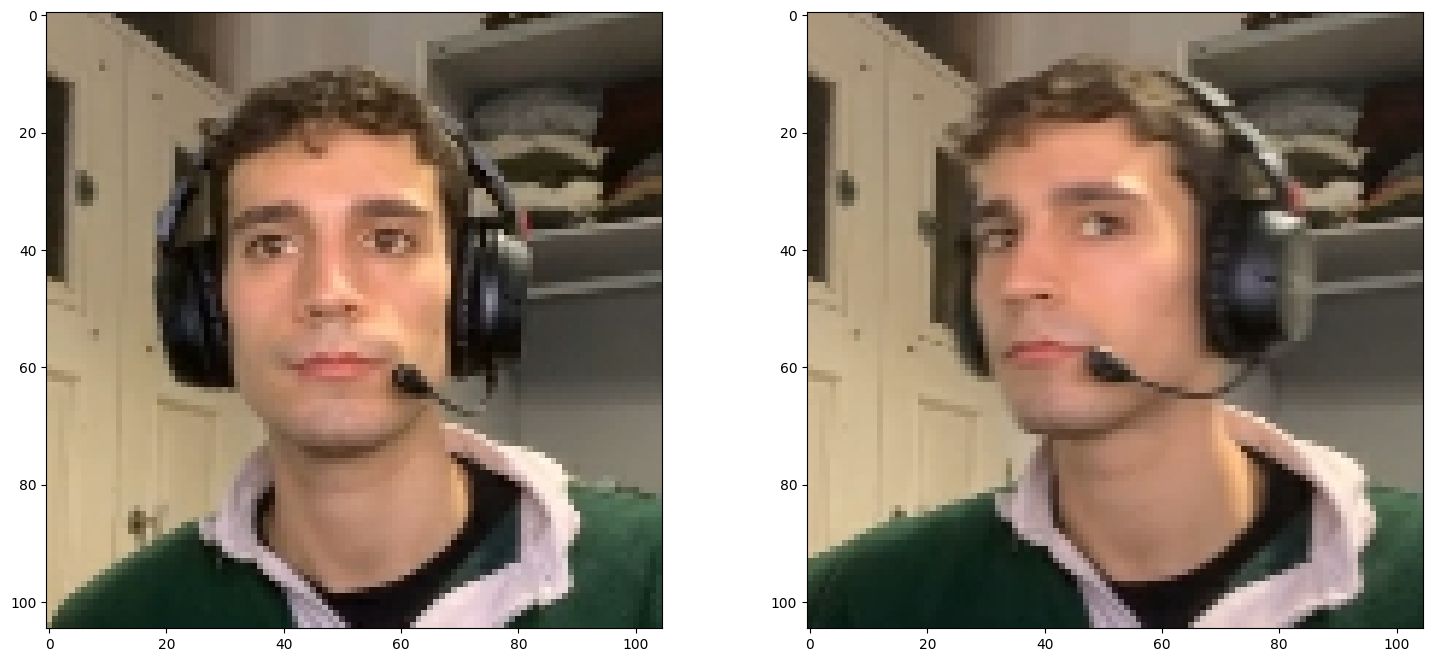

In [39]:
VIS_IMG = 1

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.imshow(test_input[VIS_IMG])

plt.subplot(1,2,2)
plt.imshow(test_val[VIS_IMG])

plt.show()

# 6. Savel model

In [92]:
# Save weights
siamese_network.save("siamesenetwork.h5")

In [106]:
# Reload model
model = tf.keras.models.load_model("siamesenetwork.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy})

In [107]:
model.predict([test_input,test_val])

c:\Users\reidp\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[9.9966598e-01],
       [1.3293828e-07],
       [1.8581641e-11],
       [4.4969383e-07],
       [1.6935341e-04],
       [1.0000000e+00],
       [9.9352008e-01],
       [9.9975044e-01],
       [3.0560793e-10],
       [2.6339874e-14],
       [1.0000000e+00],
       [9.9920088e-01],
       [3.9549977e-13],
       [3.1283385e-13],
       [9.9999893e-01],
       [5.3368014e-13]], dtype=float32)

In [108]:
model.summary()

Model: "Siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_img (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
val_img (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    inp_img[0][0]                    
                                                                 val_img[0][0]                    
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]            

# 7. Real Time Test

## 7.1 Verification

In [23]:
# Create dirs

APP_DIR = "./app_data"
VER_DIR = "ver_images"
INP_DIR = "input_images"

if not os.path.isdir(APP_DIR):
    os.mkdir(APP_DIR)
    os.mkdir(f"{APP_DIR}/{VER_DIR}")
    os.mkdir(f"{APP_DIR}/{INP_DIR}")

In [58]:
# Copy 50 random images to verification

for i in range(1,50):
    random_file=random.choice(os.listdir("./data/positive"))
    OLD_PATH = os.path.join("./data/positive",random_file)
    NEW_PATH = os.path.join(f"{APP_DIR}/{VER_DIR}",random_file)
    shutil.copy(OLD_PATH,NEW_PATH)

In [60]:
def verify(model, detection_threshold, verification_threshold):

    results = []

    for inp_img in os.listdir(os.path.join(f"{APP_DIR}/{INP_DIR}")):
        for img in os.listdir(os.path.join(f"{APP_DIR}/{VER_DIR}")):
            input_img = preprocess(os.path.join(f"{APP_DIR}/{INP_DIR}",inp_img))
            val_img = preprocess(os.path.join(f"{APP_DIR}/{INP_DIR}",img))

            result = model.predict(list(np.expand_dims([input_img,val_img], axis=1)))
            results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join(f"{APP_DIR}/{VER_DIR}")))

    verified = verification > verification_threshold

    return results, verified

In [3]:
import time

In [24]:
cap = cv2.VideoCapture(CAM_POS)
i = 0
while cap.isOpened():
    ret,frame = cap.read()
    
    frame = frame[Y_CAM_POS:Y_CAM_POS+FRAME,X_CAM_POS:X_CAM_POS+FRAME]

    cv2.imshow("Verification", frame)

    time.sleep(1)
    cv2.imwrite(os.path.join(f"{APP_DIR}/{INP_DIR}",f"input_img{i}.jpg"), frame)
    i+=1

    if cv2.waitKey(10) & 0xFF == ord("q") or i == 10:
        break
cap.release()
cv2.destroyAllWindows()

1
./app_data/input_images\input_img0.jpg
1
./app_data/input_images\input_img1.jpg
1
./app_data/input_images\input_img2.jpg
1
./app_data/input_images\input_img3.jpg
1
./app_data/input_images\input_img4.jpg
1
./app_data/input_images\input_img5.jpg
1
./app_data/input_images\input_img6.jpg
1
./app_data/input_images\input_img7.jpg
1
./app_data/input_images\input_img8.jpg
1
./app_data/input_images\input_img9.jpg


In [ ]:
# Verify
results, verified = verify(model,detection_threshold=0.5,verification_threshold=0.5)

print(verified)